## **Import**

In [1]:
FOLDER_PATH = r'/content/drive/MyDrive/MachineLearning-DANDL-20212/'
TRAIN_DATA_PATH = FOLDER_PATH + r'data/train.csv'
TEST_DATA_PATH = FOLDER_PATH + r'data/test.csv'

In [2]:
import os
os.listdir(FOLDER_PATH)

['data', '.ipynb_checkpoints', 'EDA.ipynb']

In [3]:
os.path.exists(FOLDER_PATH), os.path.exists(TRAIN_DATA_PATH), os.path.exists(TEST_DATA_PATH)

(True, True, True)

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
from scipy import stats
from scipy.stats import norm, normaltest
from sklearn.model_selection import train_test_split

In [6]:
train_raw = pd.read_csv(TRAIN_DATA_PATH)
test_raw = pd.read_csv(TEST_DATA_PATH)

In [7]:
train_raw.head(3)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422


## **EDA**

### **1. Which users spent most money?**

In [8]:
user_df = train_raw.loc[:, ["User_ID", "Product_ID", "Purchase"]]
user_df.head(3)

,User_ID,Product_ID,Purchase
0,1000001,P00069042,8370
1,1000001,P00248942,15200
2,1000001,P00087842,1422


In [9]:
nb_user = user_df[user_df.duplicated()].shape[0]
user_df1 = user_df.drop(columns="Purchase")
nb_user1 = user_df1[user_df1.duplicated()].shape[0]
print("Number of user buy a product more than once with same price:", nb_user)
print("Number of user buy a product more than once:", nb_user1)

Number of user buy a product more than once with same price: 0
Number of user buy a product more than once: 0


*=> Each product may be bought by an User at most 1 (may be 0).*

In [10]:
user_df2 = train_raw.drop(columns=["Product_ID", "Product_Category_1", 'Product_Category_2', 'Product_Category_3', 'Purchase'])
user_df3 = train_raw[["User_ID", "Purchase"]]

u1 = user_df3.groupby("User_ID", as_index = False).agg({'Purchase': 'sum'})
u2 = user_df3.groupby("User_ID", as_index = False).agg({'Purchase': 'count'})

user_df2 = pd.merge(user_df2, u1, on='User_ID')
user_df2.rename(columns={"Purchase":"TotalPurchase"}, inplace=True)
user_df2 = pd.merge(user_df2, u2, on='User_ID')
user_df2.rename(columns={"Purchase":"nb_products"}, inplace=True)

user_df2["Avg_money_per_product"] = round(user_df2.TotalPurchase / user_df2.nb_products, 2)

user_df2.drop_duplicates(inplace=True)
user_df2.reset_index(inplace=True, drop=True)

user_df2.sort_values(by='nb_products', ascending=False, ignore_index=True).head(7)

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,TotalPurchase,nb_products,Avg_money_per_product
0,1001680,M,26-35,20,A,3,1,8699596,1026,8479.14
1,1004277,M,36-45,16,A,0,0,10536909,979,10762.93
2,1001941,M,36-45,17,A,1,0,6817493,898,7591.86
3,1001181,M,36-45,7,A,3,1,6387961,862,7410.63
4,1000889,M,46-50,20,A,1,0,5499872,823,6682.71
5,1003618,M,55+,17,A,4+,1,5962012,767,7773.16
6,1001150,F,26-35,20,A,1,0,4728932,752,6288.47


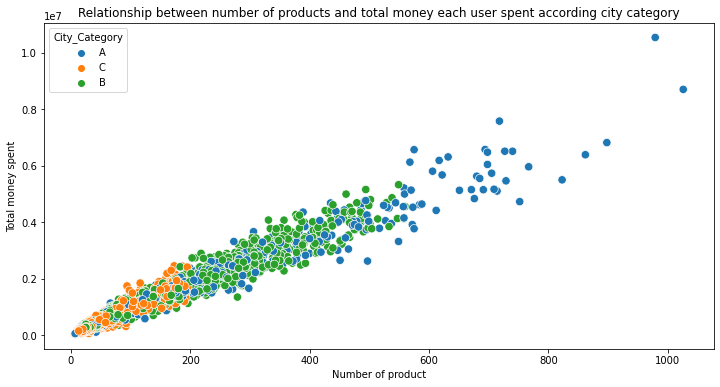

In [11]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=user_df2, x='nb_products', y='TotalPurchase', hue="City_Category", s=70)

plt.title("Relationship between number of products and total money each user spent according city category")
plt.ylabel("Total money spent")
plt.xlabel("Number of product")

plt.show()

*=> Seem that people in city A spent more for products, B is right behind and C is the least.*

*#Males = 4 #Females, the most spending users were males.*

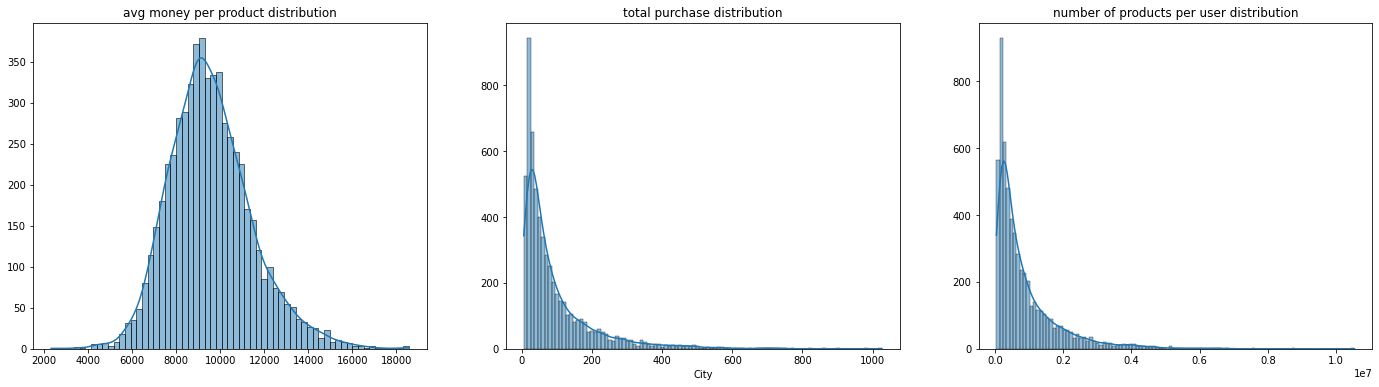

In [12]:
fig, ax = plt.subplots(1,3, figsize = (24,6))
# sns.countplot(ax = ax[0], x= 'City_Category', data= user_df, order=["A", "B", "C"], palette='Greens_r')
# sns.barplot(ax= ax[1], x = "City_Category", y="Total_Purchase", data= city_purchase, ci=None, palette='Greens_r')
# sns.barplot(ax= ax[2], x = "City_Category", y="Ratio Purchase/Person", data= city_purchase, ci=None, palette='Greens_r')
sns.histplot(ax= ax[0], data=user_df2.Avg_money_per_product, kde=True)
sns.histplot(ax= ax[1], data= user_df2.nb_products, kde= True)
sns.histplot(ax=ax[2], data= user_df2.TotalPurchase, kde = True)
ax[0].set(title="avg money per product distribution", ylabel = None, xlabel=None)
ax[1].set(title="total purchase distribution", ylabel = None, xlabel="City")
ax[2].set(title="number of products per user distribution", xlabel=None, ylabel=None)

plt.show()

In [13]:
_, p_value = normaltest(a=user_df2.Avg_money_per_product)
print("p value:", p_value)

p value: 1.4617254783853661e-78


*---> p_value is too small*

### **2. Which user use money more efficient?**

In [14]:
user_df4 = train_raw.loc[:, ["Product_ID", "Purchase"]]
user_df5 = train_raw.loc[:, ["User_ID", "Product_ID", "Purchase"]]

u4 = user_df4.groupby(by='Product_ID', as_index=False).agg({"Purchase":"mean"})
u4.rename(columns={"Purchase":"Avg_price"}, inplace=True)

user_df5 = pd.merge(user_df5, u4, on='Product_ID')
user_df5['Saving'] = round(user_df5.Avg_price - user_df5.Purchase, 2)

user_df5.head(5)

,User_ID,Product_ID,Purchase,Avg_price,Saving
0,1000001,P00069042,8370,11870.863436,3500.86
1,1000149,P00069042,10715,11870.863436,1155.86
2,1000541,P00069042,11037,11870.863436,833.86
3,1000698,P00069042,8009,11870.863436,3861.86
4,1000951,P00069042,13346,11870.863436,-1475.14


In [15]:
u5 = user_df5.groupby(by="User_ID", as_index=False).agg({"Saving":"sum"})
user_df2 = pd.merge(user_df2, u5, on="User_ID")
print("number of features in user_df2:",user_df2.shape[1])
user_df2.head(4)
### if user_df2 has more than 11 features, run again assignment of user_df2

number of features in user_df2: 11


,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,TotalPurchase,nb_products,Avg_money_per_product,Saving
0,1000001,F,0-17,10,A,2,0,334093,35,9545.51,-7174.27
1,1000002,M,55+,16,C,4+,0,810472,77,10525.61,11770.64
2,1000003,M,26-35,15,A,3,0,341635,29,11780.52,-13024.32
3,1000004,M,46-50,7,B,2,1,206468,14,14747.71,-4685.82


In [16]:
user_df2['saving_score'] = round(user_df2.Saving / user_df2.TotalPurchase, 2)
user_df2.sort_values(by="saving_score", ignore_index=True, ascending=False).head(6)

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,TotalPurchase,nb_products,Avg_money_per_product,Saving,saving_score
0,1003598,M,55+,1,A,2,0,113331,42,2698.36,222084.38,1.96
1,1004486,M,36-45,8,C,1,0,69562,30,2318.73,117960.88,1.70
2,1002744,M,18-25,17,C,1,1,314780,92,3421.52,455274.69,1.45
3,1004539,M,36-45,19,C,0,0,295996,70,4228.51,378837.70,1.28
4,1004636,M,18-25,2,B,2,1,57805,16,3612.81,70365.35,1.22
5,1005944,F,18-25,10,C,4+,0,53996,15,3599.73,57382.24,1.06


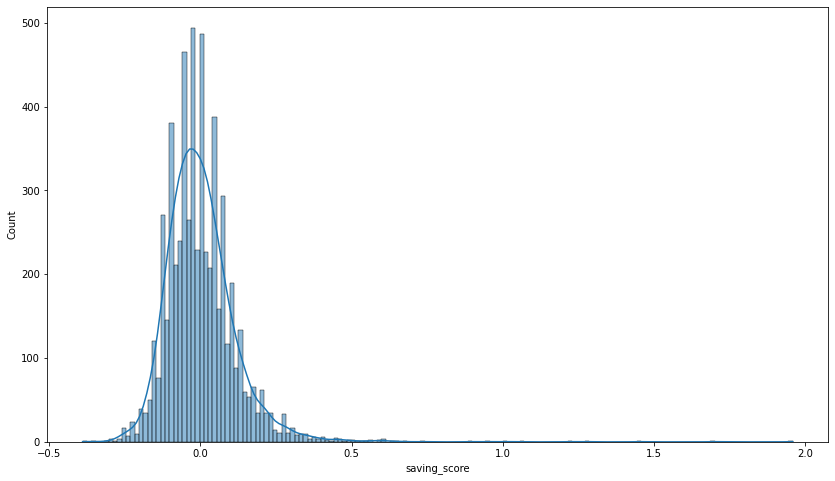

In [17]:
plt.figure(figsize=(14,8))
sns.histplot(data=user_df2.saving_score, kde=True)

In [18]:
user_df2.groupby('City_Category').agg({"saving_score":"sum"})

,saving_score
City_Category,
A,19.33
B,18.46
C,-23.57


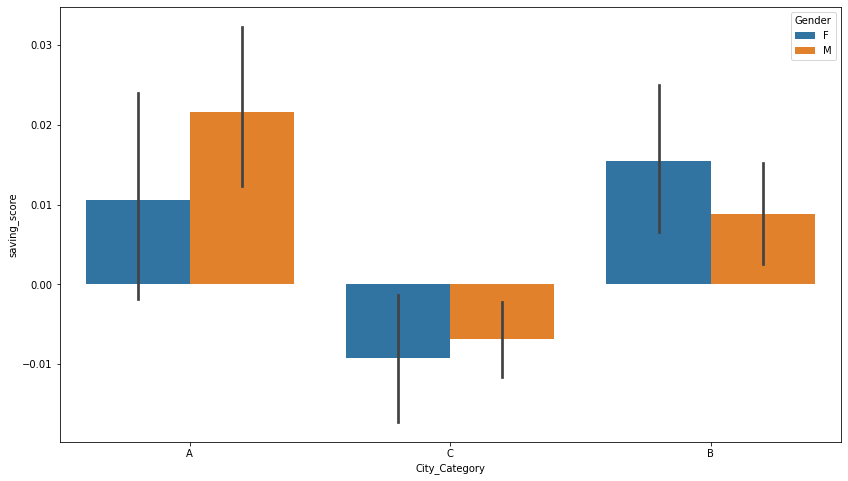

In [19]:
plt.figure(figsize=(14,8))
sns.barplot(data=user_df2, y='saving_score', x='City_Category', hue='Gender')

*=> Seem that people in city C usually buy product with higher price*

*In general, males in city A use money more efficient than females, and females in city B use money more effiecient than males in city B*

### **3. Which products are more prefer (bought most)?**

In [20]:
product_df = train_raw.loc[:,["User_ID", "Product_ID", "City_Category",  "Product_Category_1","Product_Category_2","Product_Category_3", "Purchase" ]]
product_df['Versatile'] = 3 - product_df.iloc[:,[3,4,5]].isnull().sum(axis = 1)
product_df.head()

,User_ID,Product_ID,City_Category,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Versatile
0,1000001,P00069042,A,3,NaN,NaN,8370,1
1,1000001,P00248942,A,1,6.0,14.0,15200,3
2,1000001,P00087842,A,12,NaN,NaN,1422,1
3,1000001,P00085442,A,12,14.0,NaN,1057,2
4,1000002,P00285442,C,8,NaN,NaN,7969,1


In [21]:
product_df.Versatile.value_counts()

2    209609
1    173638
3    166821
Name: Versatile, dtype: int64

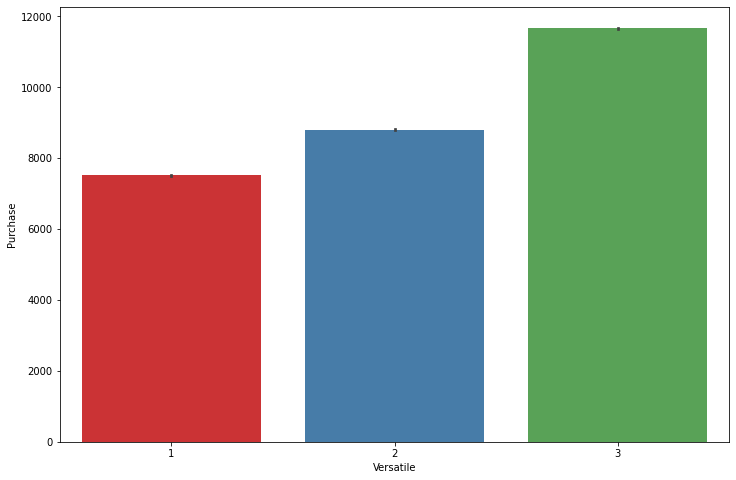

In [22]:
plt.figure(figsize=(12,8))
sns.barplot(data=product_df, x='Versatile', y='Purchase', palette="Set1")

plt.show()

*In general, we can see Versatile score: which product more versatile will have high price*

In [42]:
p1 = product_df.loc[:, ["Product_ID", 'Purchase']]
p1.rename(columns={"Purchase":"total_purchase"}, inplace=True)
p1 = p1.groupby(by="Product_ID", as_index=False).agg({"total_purchase":"sum"})

p2 = product_df.loc[:, ["Product_ID", 'Purchase']]
p2.rename(columns={"Purchase":"nb_products"}, inplace=True)
p2 = p2.groupby(by="Product_ID", as_index=False).agg({"nb_products":"count"})


product_df1 = product_df.loc[:, ["Product_ID",  "Product_Category_1","Product_Category_2","Product_Category_3", "Versatile"]]
product_df1.drop_duplicates(inplace=True)

product_df1 = pd.merge(product_df1, p1, on='Product_ID')
product_df1 = pd.merge(product_df1, p2, on='Product_ID')

product_df1.head()

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3,Versatile,total_purchase,nb_products
0,P00069042,3,NaN,NaN,1,2694686,227
1,P00248942,1,6.0,14.0,3,9472642,581
2,P00087842,12,NaN,NaN,1,126265,102
3,P00085442,12,14.0,NaN,2,496203,341
4,P00285442,8,NaN,NaN,1,1561631,203


In [46]:
product_df1['avg_price'] = round(product_df1.total_purchase / product_df1.nb_products, 2)
product_df1.head()

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3,Versatile,total_purchase,nb_products,avg_price
0,P00069042,3,NaN,NaN,1,2694686,227,11870.86
1,P00248942,1,6.0,14.0,3,9472642,581,16304.03
2,P00087842,12,NaN,NaN,1,126265,102,1237.89
3,P00085442,12,14.0,NaN,2,496203,341,1455.14
4,P00285442,8,NaN,NaN,1,1561631,203,7692.76


In [55]:
product_df1.sort_values(by= 'nb_products', ascending=False, ignore_index=True).head(7)

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3,Versatile,total_purchase,nb_products,avg_price
0,P00265242,5,8.0,NaN,2,14165515,1880,7534.85
1,P00025442,1,2.0,9.0,3,27995166,1615,17334.47
2,P00110742,1,2.0,8.0,3,26722309,1612,16577.11
3,P00112142,1,2.0,14.0,3,24216006,1562,15503.20
4,P00057642,1,15.0,16.0,3,23102780,1470,15716.18
5,P00184942,1,8.0,17.0,3,24334887,1440,16899.23
6,P00046742,1,2.0,15.0,3,21152882,1438,14709.93


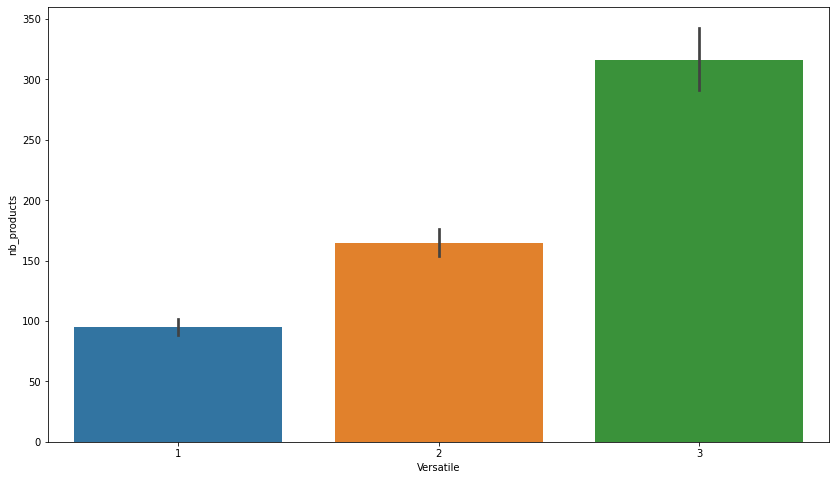

In [52]:
plt.figure(figsize=(14,8))
sns.barplot(data=product_df1, x='Versatile', y='nb_products', estimator=np.mean)

*=> Seem that in average, a product type 3 is bought more than a product type 2 and type 1, type 1 = 1/2 type 2*

### Draft

In [ ]:
product_df = user_df.drop(columns="User_ID")
product_df1 = product_df.groupby("Product_ID", as_index = False).agg({"Purchase": "mean"})

plt.figure(figsize=(14, 8))
sns.histplot(data=product_df1.Purchase,  kde= True)
plt.title("Average product price distribution")

plt.show()

In [ ]:
product_df = train_raw.copy()
product_df.head(3)

In [ ]:
product_df['Versatile'] = 3 - product_df.iloc[:,[8, 9, 10]].isnull().sum(axis = 1)

In [ ]:
product1 = product_df[product_df.Efficiency == 1]
product2 = product_df[product_df.Efficiency == 2]
product3 = product_df[product_df.Efficiency == 3]
# sns.histplot(data=product1.Purchase)


In [ ]:
# sns.scatterplot(data= product_df, x='')

In [ ]:
# sns.barplot(data=product_df, x="Occupation", y='Purchase', hue='Efficiency')
# plt.show()

In [ ]:
sns.boxplot(data=product_df, x='Age', y='Purchase', hue='Efficiency')

In [ ]:
plt.figure(figsize=(14,8))
# sns.kdeplot(data=product1, x='Purchase')
sns.histplot(x=product1.Purchase, kde=True)
# sns.kdeplot()

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (24,6))
sns.histplot(x=product1.Purchase, ax=ax[0])
sns.histplot(x=product2.Purchase, ax=ax[1])
sns.histplot(x=product3.Purchase, ax=ax[2])

plt.show()

In [ ]:
product1.Purchase.describe()

In [ ]:
product2.Purchase.describe()

In [ ]:
product3.Purchase.describe()

In [ ]:
sns.barplot(data=product_df, x='City_Category', y='Purchase', hue='Efficiency')

*Seem that efficiency low -> price low*

In [ ]:
sns.boxplot(data=product_df, x='City_Category', y='Purchase', hue='Efficiency')

In [ ]:
sns.barplot(data=product_df, x='Efficiency', y='Purchase', hue='Marital_Status')

In [ ]:
product_df.Efficiency.value_counts()

In [ ]:
sns.heatmap(data=product_df.corr(), annot=True)

In [ ]:
plt.figure(figsize=(14,8))
sns.barplot(x='Product_Category_1', y='Purchase', data=product_df, hue='Efficiency')

### có vẻ không hợp lý lắm

**Which kinds of products that were bought most?**

In [ ]:
product_df.head(3)

In [ ]:
product_df2 = product_df.copy()
product_df2.loc[:, ["User_ID", "Product_ID", "Purchase", "Efficiency"]]
gr_product = product_df2.groupby(by="Product_ID", as_index=False).agg({"User_ID":"count", "Purchase":"sum", "Efficiency":"mean"})
gr_product.rename(columns={"User_ID":"nb_Purchase"}, inplace=True)
# sns.histplot(data=gr_product, x="Purchase", hue="Efficiency")
sns.histplot(data= gr_product.Purchase/ gr_product.nb_Purchase)

In [ ]:
gr_product["avg_Price"]= round(gr_product.Purchase / gr_product.nb_Purchase,2)

In [ ]:
gr_product.sort_values(by=["nb_Purchase", "Purchase", "avg_Price"], ignore_index=True, ascending=False).head(4)

In [ ]:
plt.figure(figsize= (14,8))
sns.scatterplot(data=gr_product, x='nb_Purchase',y="avg_Price" , hue="Efficiency", palette="Set2")

plt.show()

**Which kinds of products that**